In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime, timedelta

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/household_power_consumption.txt',sep=";")

<ipython-input-10-e7ba98df5a9e>:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/datasets/household_power_consumption.txt',sep=";")


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

<ipython-input-11-b9c6864122be>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
# Converting string object types to numbers
df.replace(['?', 'nan', np.nan], -1, inplace=True)
num_vars= ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for i in num_vars:
    df[i] = pd.to_numeric(df[i])
imp = SimpleImputer(missing_values=-1, strategy='mean')
df[num_vars] = imp.fit_transform(df[num_vars])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   datetime64[ns]
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 142.5+ MB


In [ ]:
# Group by day and calculate mean
df = df.groupby(pd.Grouper(key='Date', freq='D')).mean().reset_index()
df.set_index('Date', inplace=True)

<ipython-input-13-2dea247b1e6c>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(pd.Grouper(key='Date', freq='D')).mean().reset_index()


<Axes: xlabel='Date'>

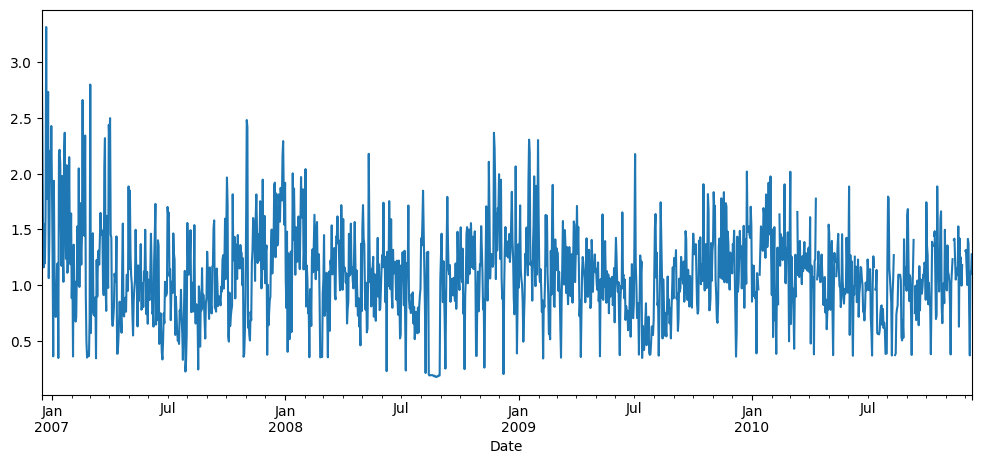

In [ ]:
df['Global_active_power'].plot(figsize=(12,5))

In [ ]:
df.fillna(df.mean(), inplace=True)

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Global_active_power'], trace=True,suppress_warnings=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1143.486, Time=1.93 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1571.420, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1173.013, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1277.308, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4590.651, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1149.312, Time=1.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1136.144, Time=1.45 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1156.264, Time=0.76 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1161.526, Time=0.29 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1145.724, Time=1.90 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1155.370, Time=0.60 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1135.266, Time=4.09 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.58 sec
 ARIMA(3,0,3)(0,0,0)[0] in

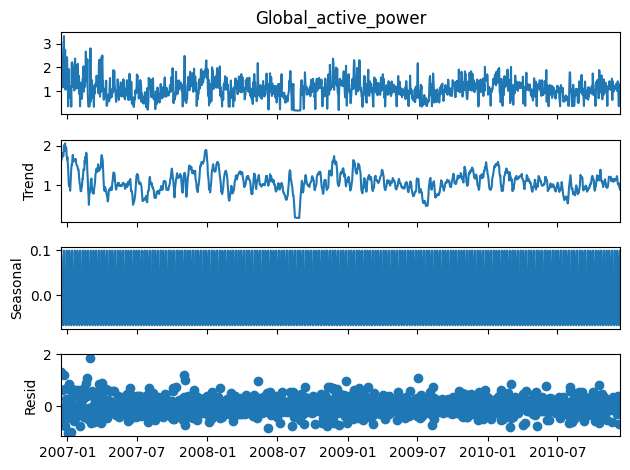

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Global_active_power'], model='additive',extrapolate_trend='freq')
result.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

check_stationarity(df['Global_active_power'])

The series is stationary


In [ ]:
seasonal = result.seasonal
check_stationarity(seasonal)

The series is stationary


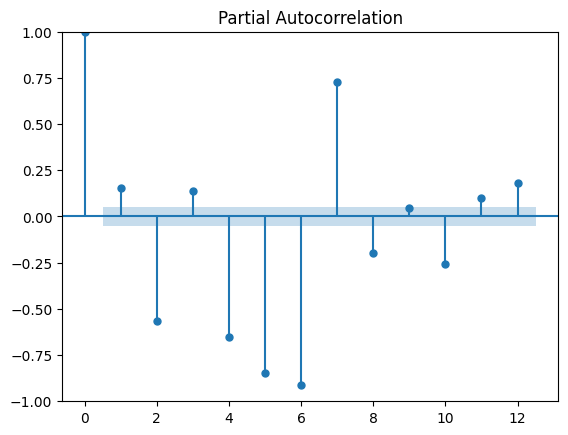

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal, lags =12)
plt.show()


# p value can be 1 , 7 , 12

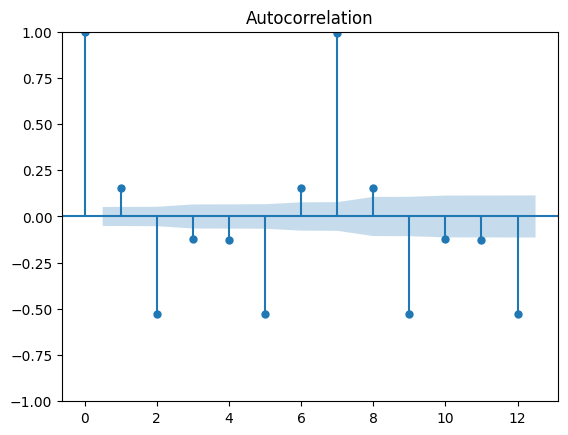

In [ ]:
plot_acf(seasonal, lags =12)
plt.show()
# q = 0, 7

In [ ]:
print(df.shape)
train=df.iloc[:-200]
test=df.iloc[-200:]
print(train.shape,test.shape)

(1457, 7)
(1257, 7) (200, 7)


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming train is your DataFrame and exog_train contains the exogenous variables
exog_train = train[['Global_intensity']]

# Fit the ARIMA model with exogenous variables
model = ARIMA(train['Global_active_power'], order=(3, 0, 2), exog=exog_train)
model_fit = model.fit()
model_fit.summary()

#  ,seasonal_order=(2, 1, 1, 7)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                 1257
Model:                  ARIMA(3, 0, 2)   Log Likelihood                3606.740
Date:                 Tue, 02 Apr 2024   AIC                          -7197.479
Time:                         13:59:20   BIC                          -7156.387
Sample:                     12-16-2006   HQIC                         -7182.036
                          - 05-25-2010                                         
Covariance Type:                   opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0140      0.002     -7.889      0.000      -0.018      -0.011
Global_intensity     0.2389      0.000   1098.251      0.000       0.238       0.239
ar.L1                0.1866      0.392      0.476      0.634      -0.581       0.954
ar.L2                0.1384      0.315      0.439      0.660      -0.479       0.756
ar.L3                0.1994      0.089      2.239      0.025       0.025       0.374
ma.L1                0.3141      0.392      0.801      0.423      -0.454       1.082
ma.L2                0.1601      0.176      0.911      0.362      -0.184       0.505
sigma2               0.0002   6.32e-06     29.788      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                69.57
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.23
Prob(H) (two-sided):                  0.68   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Assuming model_fit is your fitted ARIMA model and exog_test contains the exogenous variables for the test data
exog_test = test[['Global_intensity']]

# Generate predictions for the test data
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=exog_test)

In [ ]:
# Calculate root mean squared error (RMSE)
rmse = sqrt(mean_squared_error(predictions, test['Global_active_power']))
print('RMSE:', rmse)

RMSE: 0.014883065572244796


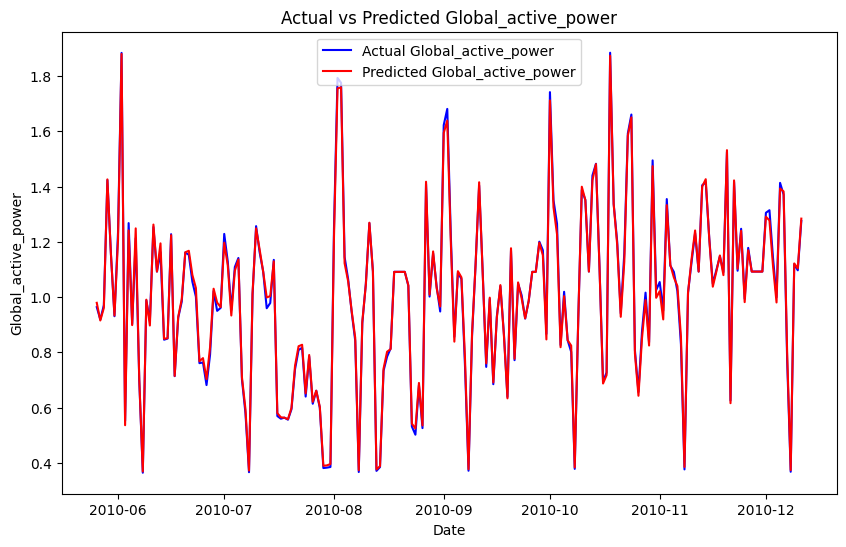

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Global_active_power'], label='Actual Global_active_power', color='blue')
plt.plot(test.index, predictions, label='Predicted Global_active_power', color='red')
plt.xlabel('Date')
plt.ylabel('Global_active_power')
plt.title('Actual vs Predicted Global_active_power')
plt.legend()
plt.show()

In [ ]:
# Fit the ARIMA model with exogenous variables
model = ARIMA(train['Global_active_power'], order=(3, 0, 2))
model_fit = model.fit()
model_fit.summary()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                 1257
Model:                  ARIMA(3, 0, 2)   Log Likelihood                -515.873
Date:                 Tue, 02 Apr 2024   AIC                           1045.746
Time:                         13:59:31   BIC                           1081.701
Sample:                     12-16-2006   HQIC                          1059.259
                          - 05-25-2010                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1313      0.067     16.940      0.000       1.000       1.262
ar.L1          0.4709      0.070      6.692      0.000       0.333       0.609
ar.L2          0.8982      0.082     10.929      0.000       0.737       1.059
ar.L3         -0.3842      0.032    -12.050      0.000      -0.447      -0.322
ma.L1         -0.0378      0.072     -0.524      0.600      -0.179       0.103
ma.L2         -0.8631      0.066    -13.159      0.000      -0.992      -0.735
sigma2         0.1330      0.004     30.626      0.000       0.124       0.141
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               171.13
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# User input
user_input = input("Enter Date that you want YYYY-MM-DD ")

# Convert user input to datetime object
user_date = datetime.strptime(user_input, '%Y-%m-%d')

# Calculate the end date for the forecast (7 days ahead)
forecast_end_date = user_date + timedelta(days=7)

# Generate out-of-sample predictions for the future without exogenous variables
forecast_future = model_fit.predict(start=user_date, end=forecast_end_date)

forecast_future


Enter Date that you want YYYY-MM-DD 2009-05-13


2009-05-13    1.336441
2009-05-14    0.985552
2009-05-15    1.094068
2009-05-16    1.043426
2009-05-17    1.210490
2009-05-18    1.097202
2009-05-19    0.969263
2009-05-20    1.104747
Freq: D, Name: predicted_mean, dtype: float64

<Axes: >

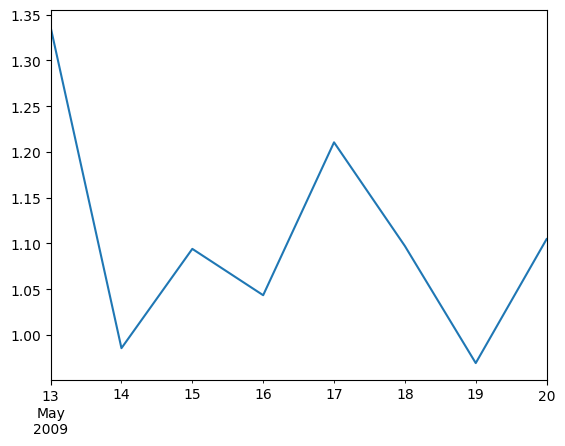

In [ ]:
forecast_future.plot()